# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from wordcloud import WordCloud

# Configs

In [2]:
pd.set_option('display.max_colwidth', 50)

# Data Loading and Cleaning

In [3]:
df1 = pd.read_csv('youtoxic_english_1000.csv')
df1.drop(['CommentId', 'VideoId'], axis=1, inplace=True, errors='ignore')

df2 = pd.read_csv('modified_train.csv')

df3 = pd.read_csv('dailytext.csv')

df1['Toxic'] = df1.iloc[:, 2:].any(axis=1)
df1_processed = df1[['Text', 'Toxic']].rename(columns={'comment_text': 'Text'})

df_more = df2[['more_toxic']].rename(columns={'more_toxic': 'Text'})
df_more['Toxic'] = 1

df_less = df2[['less_toxic']].rename(columns={'less_toxic': 'Text'})
df_less['Toxic'] = 0

df2_combined = pd.concat([df_more, df_less], ignore_index=True)

df3_processed = df3[['dialog']].rename(columns={'dialog': 'Text'})
df3_processed['Toxic'] = 0

df = pd.concat([df1_processed, df2_combined, df3_processed], ignore_index=True)
df = df.drop_duplicates(subset='Text')

In [4]:
df.shape

(153896, 2)

# Text Preprocessing

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9$@!\s]', '', text)
    words = nltk.word_tokenize(text)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word not in stopwords]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['cleaned_text'] = df['Text'].apply(preprocess_text)

In [6]:
df.head()

,Text,Toxic,cleaned_text
0,If only people would just take a step back and...,0,people would take step back make case wasnt an...
1,Law enforcement is not trained to shoot to app...,1,law enforcement trained shoot apprehend traine...
2,\nDont you reckon them 'black lives matter' ba...,1,dont reckon black life matter banner held whit...
3,There are a very large number of people who do...,0,large number people like police officer called...
4,"The Arab dude is absolutely right, he should h...",0,arab dude absolutely right shot 6 extra time s...


In [7]:
df.tail()

,Text,Toxic,cleaned_text
461473,"['Hello , I bought a pen in your shop just bef...",0,hello bought pen shop yes thank much came back...
461474,['Do you have any seats available ? ' ' Yes . ...,0,seat available yes way please whats special to...
461475,"['Uncle Ben , how did the Forbidden City get t...",0,uncle ben forbidden city get name well feudal ...
461476,"['May I help you , sir ? ' ' I want a pair of ...",0,may help sir want pair locus take look one dis...
461477,"['Could I have the check , please ? ' "" Okay ....",0,could check please okay ill minute


In [8]:
df.shape

(153896, 3)

# Train-Test Split

In [9]:
X = df['cleaned_text']
y = df['Toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

# Data Visualization

In [10]:
toxic_text = " ".join(df.loc[df['Toxic'] == 1, 'cleaned_text'])
nontoxic_text = " ".join(df.loc[df['Toxic'] == 0, 'cleaned_text'])

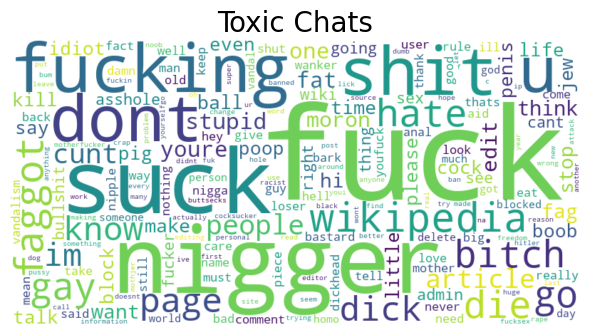

In [11]:
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(toxic_text)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.title('Toxic Chats', fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()

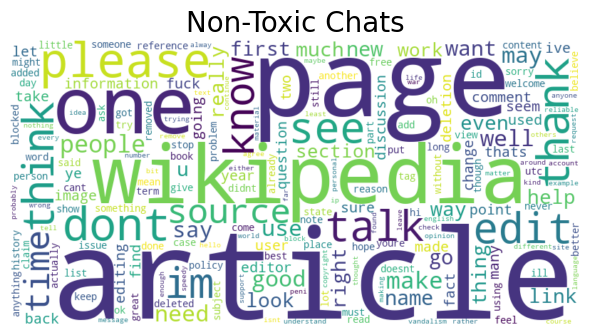

In [12]:
wordcloud_nontoxic = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(nontoxic_text)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_nontoxic, interpolation='bilinear')
plt.title('Non-Toxic Chats', fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()

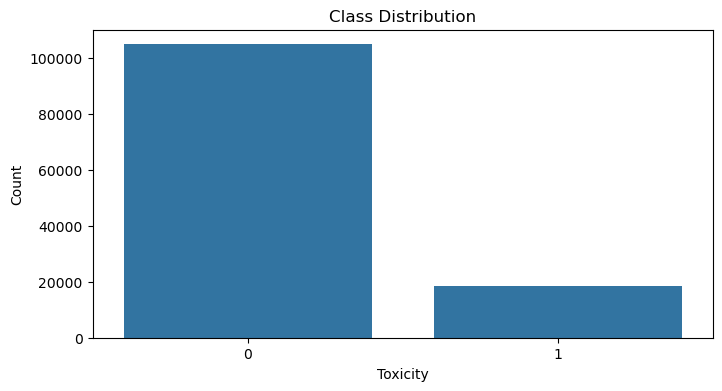

In [13]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution")
plt.xlabel("Toxicity")
plt.ylabel("Count")
plt.show()

In [14]:
df.shape

(153896, 3)

# Pipeline

In [15]:
class ThresholdLinearSVC(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.0, max_iter=10000):
        self.threshold = threshold
        self.max_iter = max_iter
        self.model = LinearSVC(max_iter=self.max_iter)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def decision_function(self, X):
        return self.model.decision_function(X)

    def predict(self, X):
        scores = self.decision_function(X)
        return (scores > self.threshold).astype(int)

    def predict_proba(self, X):
        scores = self.decision_function(X)
        probs = 1 / (1 + np.exp(-scores))
        return np.vstack([1 - probs, probs]).T

In [16]:
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('smote', SMOTE(random_state=69)),
    ('svc', ThresholdLinearSVC())
])

pipeline.fit(X_train, y_train)

c:\Users\dave08\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('smote', SMOTE(random_state=69)),
                ('svc', ThresholdLinearSVC())])

In [17]:
tfidf_vectorizer = pipeline.named_steps['tfidf']
svc_model = pipeline.named_steps['svc'].model

feature_names = tfidf_vectorizer.get_feature_names_out()

coefficients = svc_model.coef_[0]

coef_df = pd.DataFrame({'Word': feature_names, 'Coefficient': coefficients})

toxic_words = coef_df.sort_values('Coefficient', ascending=False)

print("Top 20 words most indicative of toxicity:")
print(toxic_words.head(20))

print("\nTop 20 words most indicative of non-toxicity:")
print(toxic_words.tail(20).sort_values('Coefficient', ascending=True))

Top 20 words most indicative of toxicity:
                    Word  Coefficient
4882  wikipediaquestions     4.396760
2225             idiotic     2.201965
4028                sieg     2.185125
2137                hist     2.182140
902          cocksucking     1.937122
1858                foul     1.896996
4700              uuuuuu     1.787781
901           cocksucker     1.767493
2558          leadership     1.707313
491             basement     1.703497
2224               idiot     1.581615
2865               moron     1.578131
4219               steal     1.572018
4270           stupidity     1.485038
2573             leftist     1.455073
1301           destroyed     1.453875
685                bully     1.430414
2208           hypocrite     1.420669
2776            mentally     1.408879
1279               depth     1.347304

Top 20 words most indicative of non-toxicity:
                Word  Coefficient
4009        shopping    -2.675371
4534         tourist    -2.206410
3036       

In [18]:
#MANUAL COEFFICIENT ADJUSTMENT

feature_to_index = {word: idx for idx, word in enumerate(feature_names)}

# Define the words you want to tune and their new desired coefficients
# Example: {'word_to_make_more_toxic': 2.0, 'word_to_make_less_toxic': -2.0}
manual_adjustments = {
    # Add your words and target coefficients here.
    # Ensure the words are in the same form as they appear in 'feature_names'
    # (e.g., lowercase, lemmatized if that's what your preprocessing does).
    # "exampleword1": 1.5,  # Increase toxicity score
    # "exampleword2": -1.0  # Decrease toxicity score (make more non-toxic)
    "woman": -0.5
}

print("Applying manual coefficient adjustments...")
for word, new_coefficient in manual_adjustments.items():
    if word in feature_to_index:
        index = feature_to_index[word]
        original_coefficient = svc_model.coef_[0][index]
        svc_model.coef_[0][index] = new_coefficient
        print(f"Adjusted coefficient for '{word}': {original_coefficient:.4f} -> {new_coefficient:.4f}")
    else:
        print(f"Warning: Word '{word}' not found in model features. No adjustment made.")

print("Manual adjustments applied.")

coefficients_updated = svc_model.coef_[0]
coef_df_updated = pd.DataFrame({'Word': feature_names, 'Coefficient': coefficients_updated})

print("\nUpdated coefficients for manually adjusted words (if any were found):")
for word in manual_adjustments.keys():
    if word in coef_df_updated['Word'].values:
        print(coef_df_updated[coef_df_updated['Word'] == word])
    else:
        print(f"'{word}' still not found after attempting adjustment (this shouldn't happen if found earlier).")


Applying manual coefficient adjustments...
Adjusted coefficient for 'woman': -0.0635 -> -0.5000
Manual adjustments applied.

Updated coefficients for manually adjusted words (if any were found):
       Word  Coefficient
4916  woman         -0.5


In [19]:
word_to_check = "beautiful" 

if word_to_check in coef_df['Word'].values:
    word_coefficient = coef_df[coef_df['Word'] == word_to_check]
    print(f"Coefficient for '{word_to_check}':")
    print(word_coefficient)
else:
    print(f"'{word_to_check}' not found in the model's features.")
    print("It might have been removed during preprocessing or is not among the top TF-IDF features.")


Coefficient for 'beautiful':
          Word  Coefficient
513  beautiful    -0.225868


# Threshold Tuning

In [20]:
svc_step = pipeline.named_steps['svc']
X_train_vec = pipeline.named_steps['tfidf'].transform(X_train)
y_scores_train = svc_step.model.decision_function(X_train_vec)

thresholds = np.linspace(-1, 1, 100)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_thresh = (y_scores_train > threshold).astype(int)
    f1 = f1_score(y_train, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold Found: {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")

Best Threshold Found: 0.2121
Best F1 Score: 0.5996


In [21]:
pipeline.named_steps['svc'].threshold = best_threshold

# Evaluation on Train


Train Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91    104775
           1       0.51      0.73      0.60     18341

    accuracy                           0.86    123116
   macro avg       0.73      0.80      0.76    123116
weighted avg       0.88      0.86      0.87    123116



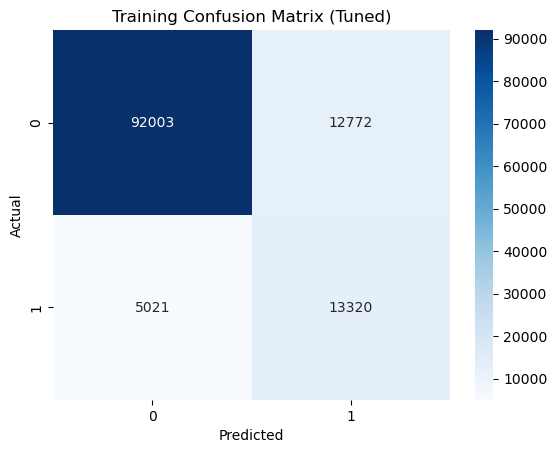

In [22]:
y_pred_train = pipeline.predict(X_train)

print("\nTrain Classification Report:")
print(classification_report(y_train, y_pred_train))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title("Training Confusion Matrix (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluation on Test


Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     26194
           1       0.47      0.68      0.56      4586

    accuracy                           0.84     30780
   macro avg       0.71      0.77      0.73     30780
weighted avg       0.87      0.84      0.85     30780



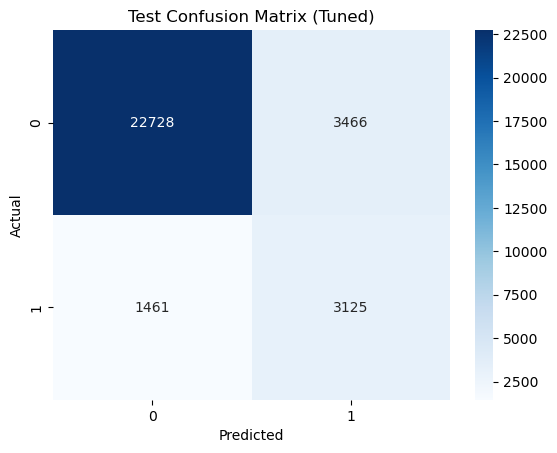

In [23]:
X_test_vec = pipeline.named_steps['tfidf'].transform(X_test)
y_scores_test = svc_step.model.decision_function(X_test_vec)

y_pred_test = (y_scores_test > best_threshold).astype(int)

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))

conf_matrix_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title("Test Confusion Matrix (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Manual test

In [24]:
example_sentence = "Test text here"
print(f"Original sentence: {example_sentence}\n")

cleaned_sentence = preprocess_text(example_sentence)
print(f"Cleaned text: {cleaned_sentence}")

tfidf_vectorizer = pipeline.named_steps['tfidf']

svc_model = pipeline.named_steps['svc'].model 
model_coefficients = svc_model.coef_[0]
model_intercept = svc_model.intercept_[0]
feature_names = tfidf_vectorizer.get_feature_names_out()
current_threshold = pipeline.named_steps['svc'].threshold

feature_to_index = {word: idx for idx, word in enumerate(feature_names)}

example_vec = tfidf_vectorizer.transform([cleaned_sentence])

total_impact_score = svc_model.decision_function(example_vec)[0]
print(f"Total impact score: {total_impact_score:.4f}")

print(f"Threshold: {current_threshold:.4f}")

prediction_result = pipeline.predict([example_sentence])[0]
prediction_label = "Toxic" if prediction_result == 1 else "Non-Toxic"
print(f"Prediction: {prediction_label} ({prediction_result})")


words_in_cleaned_sentence = cleaned_sentence.split()
toxic_push_words = []
nontoxic_push_words = []


print("\nWords pushing toward toxic:")
present_feature_indices = example_vec.indices
for idx in present_feature_indices:
    word = feature_names[idx]
    if word in words_in_cleaned_sentence: 
        tfidf_score_for_word_in_sentence = example_vec[0, idx]
        coefficient_for_word = model_coefficients[idx]
        impact = tfidf_score_for_word_in_sentence * coefficient_for_word
        if impact > 0:
            toxic_push_words.append((word, impact))

if toxic_push_words:
    for word, impact in sorted(toxic_push_words, key=lambda item: item[1], reverse=True):
        print(f"- {word}: {impact:.4f}")
else:
    print("None")

print("\nWords pushing toward non-toxic:")
for idx in present_feature_indices:
    word = feature_names[idx]
    if word in words_in_cleaned_sentence:
        tfidf_score_for_word_in_sentence = example_vec[0, idx]
        coefficient_for_word = model_coefficients[idx]
        impact = tfidf_score_for_word_in_sentence * coefficient_for_word
        if impact < 0:
            nontoxic_push_words.append((word, impact))

if nontoxic_push_words:
    for word, impact in sorted(nontoxic_push_words, key=lambda item: item[1]):
        print(f"- {word}: {impact:.4f}")
else:
    print("None")

Original sentence: Test text here

Cleaned text: test text
Total impact score: -0.7542
Threshold: 0.2121
Prediction: Non-Toxic (0)

Words pushing toward toxic:
None

Words pushing toward non-toxic:
- test: -0.6970
- text: -0.5419


In [25]:
import joblib
import json
import numpy as np

# Get components from your pipeline
vectorizer = pipeline.named_steps['tfidf']
svc_model = pipeline.named_steps['svc'].model
threshold = pipeline.named_steps['svc'].threshold
feature_names = vectorizer.get_feature_names_out().tolist()

# Export vectorizer and model using joblib
joblib.dump(vectorizer, 'vectorizer.joblib')
joblib.dump(svc_model, 'svc_model.joblib')

# Export model parameters as JSON for JavaScript-friendly usage
model_params = {
    'coefficients': svc_model.coef_[0].tolist(),
    'intercept': svc_model.intercept_[0],
    'threshold': threshold,
    'feature_names': feature_names
}

with open('model_params.json', 'w') as f:
    json.dump(model_params, f)